In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker and time period
ticker = "BTC-USD"
start_date = "2020-01-01"
end_date = "2024-12-31"

# Fetch the data
df = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Select relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Save to CSV
df.to_csv("btc2020_2024.csv")

print("BTC data from 2020 to 2024 saved as btc2020_2024.csv")

In [30]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('btc_2020_2024.csv', header=[0, 1], index_col=0)

# Flatten the MultiIndex columns by joining the level names
df.columns = ['_'.join(col).strip() for col in df.columns.values]

# Reset the index to have the 'Date' as a column
df.reset_index(inplace=True)

# Save the updated dataframe back to a new CSV file
df.to_csv('btc_2020_2024.csv', index=False)

print("Headers have been reformatted and multilayer index removed successfully.")


Headers have been reformatted and multilayer index removed successfully.


Device set to use cuda:0
C:\Users\S\AppData\Local\Temp\ipykernel_28968\1410811708.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  btc_df.loc[:, 'FinBERT_Score'] = btc_df['FinBERT_Score'].fillna(0)  # Fill missing sentiment scores with neutral (0)
c:\Users\S\anaconda3\envs\mlenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


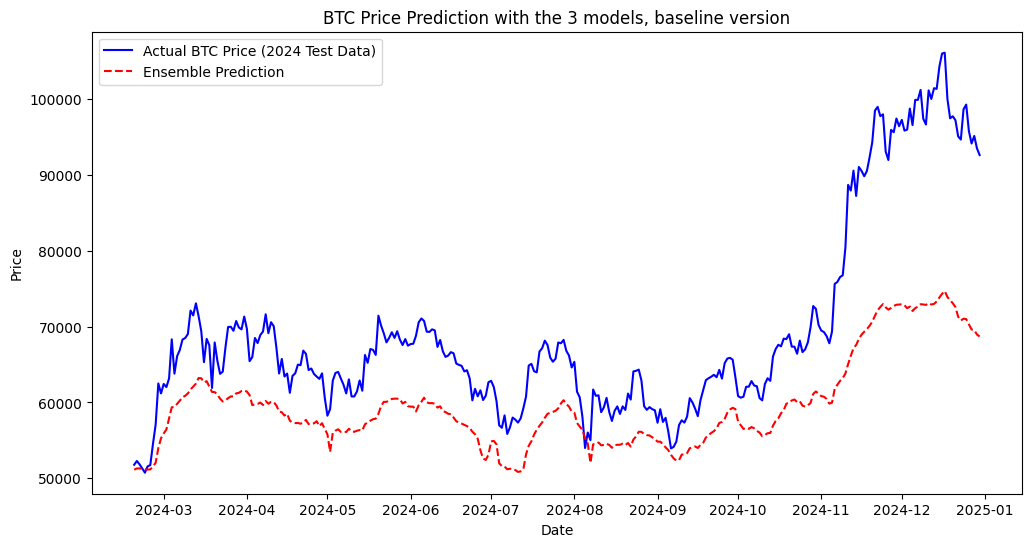

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from transformers import pipeline

# Load the BTC price data
btc_df = pd.read_csv('btc_2020_2024.csv', parse_dates=['Date'], index_col='Date')

# Load and process the chat file
chat_file = "Sentiment1.txt"
with open(chat_file, "r", encoding="utf-8") as file:
    chat_data = file.read() 

# Extract messages
pattern = r"Time: (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\nMessage: (.*?)\n(?:-|\Z)"
matches = re.findall(pattern, chat_data, re.DOTALL)

# Convert to DataFrame
sentiment_df = pd.DataFrame(matches, columns=["Timestamp", "Message"])
sentiment_df["Timestamp"] = pd.to_datetime(sentiment_df["Timestamp"])

# Initialize FinBERT sentiment analysis pipeline
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert", device=0)

# Function to analyze sentiment using FinBERT
def get_finbert_sentiment(text):
    result = finbert(text)[0]['label']
    return 1 if result == "positive" else -1 if result == "negative" else 0

# Apply FinBERT sentiment analysis
sentiment_df['FinBERT_Score'] = sentiment_df['Message'].apply(get_finbert_sentiment)

# Aggregate FinBERT sentiment scores by day
daily_sentiment = sentiment_df.groupby(sentiment_df['Timestamp'].dt.date)['FinBERT_Score'].mean().rename('FinBERT_Score')



# Merge with BTC data
btc_df = btc_df.merge(daily_sentiment, left_index=True, right_index=True, how='left')
btc_df.loc[:, 'FinBERT_Score'] = btc_df['FinBERT_Score'].fillna(0)  # Fill missing sentiment scores with neutral (0)

# Ensure data is sorted by date
btc_df = btc_df.sort_index()

# Train-Test Split (2020-2023 for training, 2024 for testing)
train_end_date = '2023-12-31'
test_start_date = '2024-01-01'

btc_2020_2023 = btc_df.loc[btc_df.index <= train_end_date].copy()
btc_2024 = btc_df.loc[btc_df.index >= test_start_date].copy()

# Function to calculate technical indicators
def calculate_indicators(df):
    df['SMA_50'] = df['Close_BTC-USD'].rolling(window=50).mean()
    df['EMA_50'] = df['Close_BTC-USD'].ewm(span=50, adjust=False).mean()
    df['EMA_12'] = df['Close_BTC-USD'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close_BTC-USD'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['RSI_14'] = 100 - (100 / (1 + df['Close_BTC-USD'].pct_change().rolling(14).apply(lambda x: (x[x > 0].sum() / -x[x < 0].sum()) if x[x < 0].sum() != 0 else 0)))
    df['BB_Middle'] = df['Close_BTC-USD'].rolling(window=20).mean()
    df['BB_Upper'] = df['BB_Middle'] + (df['Close_BTC-USD'].rolling(window=20).std() * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['Close_BTC-USD'].rolling(window=20).std() * 2)
    return df

# Recalculate indicators for both training and test sets
btc_2020_2023 = calculate_indicators(btc_2020_2023)
btc_2024 = calculate_indicators(btc_2024)

# Drop NaNs from the training and test data after recalculating indicators
btc_2020_2023 = btc_2020_2023.dropna(subset=['SMA_50', 'EMA_50', 'MACD', 'MACD_Signal', 'RSI_14', 'BB_Upper', 'BB_Lower', 'FinBERT_Score'])
btc_2024 = btc_2024.dropna(subset=['SMA_50', 'EMA_50', 'MACD', 'MACD_Signal', 'RSI_14', 'BB_Upper', 'BB_Lower', 'FinBERT_Score'])

# Ensure all data is numeric
btc_2020_2023 = btc_2020_2023.apply(pd.to_numeric, errors='coerce')
btc_2024 = btc_2024.apply(pd.to_numeric, errors='coerce')

# Prepare the target variable (BTC price) for 2020-2023
y_train = btc_2020_2023["Close_BTC-USD"].values

# Prepare the features (X) for 2020-2023
feature_columns = ['SMA_50', 'EMA_50', 'MACD', 'MACD_Signal', 'RSI_14', 'BB_Upper', 'BB_Lower', 'FinBERT_Score']
X_train = btc_2020_2023[feature_columns].values

# Prepare test data (2024)
X_test = btc_2024[feature_columns].values
y_test = btc_2024["Close_BTC-USD"].values  # Actual values for evaluation

# Fit Random Forest model with technical indicators
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fit Autoregressive model (AutoReg)
lag = 5  # Adjust as needed
auto_model = AutoReg(y_train, lags=lag).fit()

# Prepare data for LSTM model with technical indicators
train_X_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))  # Reshape to 3D
test_X_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))  # Reshape to 3D

train_y_lstm = y_train.reshape(-1, 1)

# Define and train LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(train_X_lstm, train_y_lstm, epochs=50, verbose=0)

# Get predictions from each model on the test set
rf_predictions = rf_model.predict(X_test)
auto_predictions = auto_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
lstm_predictions = lstm_model.predict(test_X_lstm).flatten()

# Adjust LSTM predictions to match RF and AutoReg length
lstm_predictions = lstm_predictions[:len(rf_predictions)]

# Ensemble predictions (Weighted Average)
ensemble_predictions = (rf_predictions * 0.4 + lstm_predictions * 0.4 + auto_predictions * 0.2)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(btc_2024.index, y_test, label='Actual BTC Price (2024 Test Data)', color='blue')
plt.plot(btc_2024.index, ensemble_predictions, label='Ensemble Prediction', color='red', linestyle='dashed')
plt.legend()
plt.title('BTC Price Prediction with the 3 models, baseline version')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test, ensemble_predictions)
mse = mean_squared_error(y_test, ensemble_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - ensemble_predictions) / y_test)) * 100
r2 = r2_score(y_test, ensemble_predictions)

# Display the metrics
print("Ensemble Model Performance (2024 Test Set):")
print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R² Score: {r2:.4f}")


Ensemble Model Performance (2024 Test Set):
MAE  : 9686.60
MSE  : 144191426.93
RMSE : 12007.97
MAPE : 12.86%
R² Score: 0.1145


In [30]:
import re
import pandas as pd
from transformers import pipeline

# Load FinBERT model
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Read the file
with open("Sentiment1.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Updated pattern to capture full message blocks
pattern = re.compile(
    r"Time:\s*(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\n\s*Message:\s*(?P<message>.*?)(?=Sender:|\Z)", 
    re.DOTALL
)

matches = pattern.finditer(text)

data = []
for match in matches:
    timestamp = match.group("timestamp").strip()
    message = match.group("message").strip().replace("\n", " ")
    data.append({"Timestamp": timestamp, "Message": message})

df = pd.DataFrame(data)

# Filter out empty messages
df = df[df["Message"].str.strip().astype(bool)]

# Run FinBERT
results = sentiment_pipeline(df["Message"].tolist())
df["FinBERT_Label"] = [r["label"] for r in results]
df["FinBERT_Score"] = [r["score"] for r in results]

print(df.head())


Device set to use cuda:0


             Timestamp                                            Message  \
0  2025-03-13 00:06:56  Coinsauce Exclusive Performance :      Week 1 ...   
1  2025-03-06 11:35:58  Bitcoin is back at $91,500 as we gear up for T...   
2  2025-03-04 12:17:23  $1,080,000,000 liquidated from the cryptocurre...   
3  2025-02-16 13:30:49  Turn notifications on insta to stay up to date...   
4  2025-02-09 16:52:30  🚨 Our Instagram Might Be Suspended Soon 🚨     ...   

  FinBERT_Label  FinBERT_Score  
0       neutral       0.885158  
1       neutral       0.823364  
2      negative       0.851230  
3       neutral       0.921186  
4       neutral       0.574224  


Mean Squared Error (MSE) of XGBoost Meta-Model: 1352530.4465043272
Mean Absolute Error (MAE) of XGBoost Meta-Model: 893.6275464794304
Root Mean Squared Error (RMSE) of XGBoost Meta-Model: 1162.9834248622494
R² Score of XGBoost Meta-Model: 0.9916941471853506


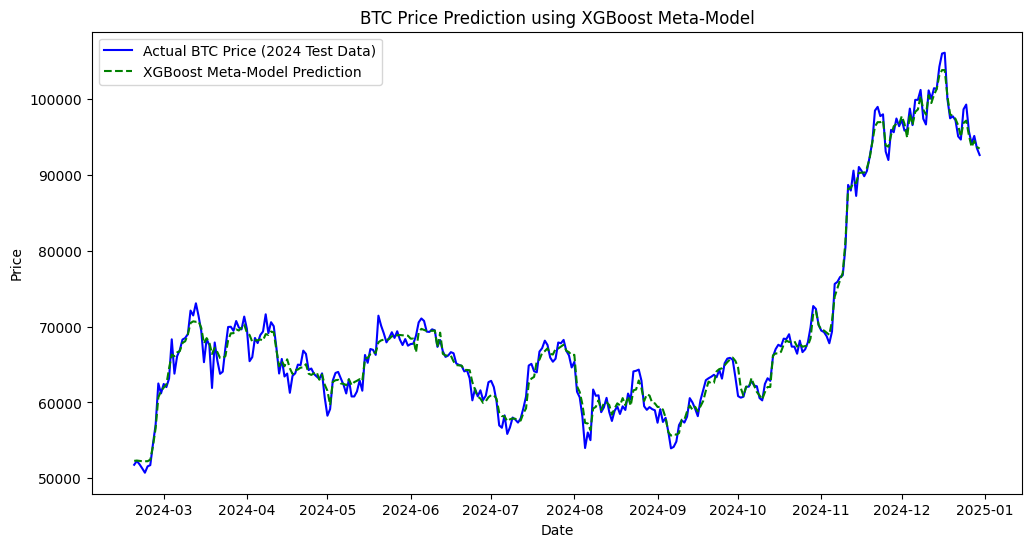

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prepare the dataset for XGBoost
# Stack the predictions of the individual models (RF, AutoReg, LSTM)
X_meta_train = np.column_stack((rf_predictions, auto_predictions, lstm_predictions))

# Define the XGBoost meta-model with adjusted parameters
meta_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,  # You may want to tune this number as well
    random_state=42,
    max_depth=4,  # Reduced depth to limit tree complexity
    min_child_weight=3,  # Increased to make the model more conservative
    subsample=0.8,  # Use 80% of data for each tree
    colsample_bytree=0.8,  # Use 80% of features for each tree
    learning_rate=0.05,  # Smaller learning rate
    gamma=0.1  # Adds regularization
)
meta_model.fit(X_meta_train, y_test)

# Get predictions from the meta-model
xgb_predictions = meta_model.predict(X_meta_train)

# Evaluate the performance using multiple metrics
mse = mean_squared_error(y_test, xgb_predictions)
mae = mean_absolute_error(y_test, xgb_predictions)
r2 = r2_score(y_test, xgb_predictions)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE) of XGBoost Meta-Model: {mse}')
print(f'Mean Absolute Error (MAE) of XGBoost Meta-Model: {mae}')
print(f'Root Mean Squared Error (RMSE) of XGBoost Meta-Model: {rmse}')
print(f'R² Score of XGBoost Meta-Model: {r2}')


# Plot the results
plt.figure(figsize=(12, 6))

# Check if y_test and xgb_predictions align with the indices of btc_2024
if len(xgb_predictions) == len(y_test):
    # Plot actual vs. predicted
    plt.plot(btc_2024.index, y_test, label='Actual BTC Price (2024 Test Data)', color='blue')
    plt.plot(btc_2024.index, xgb_predictions, label='XGBoost Meta-Model Prediction', color='green', linestyle='dashed')
else:
    print("Error: The lengths of the predictions and actual data do not match.")

plt.legend()
plt.title('BTC Price Prediction using XGBoost Meta-Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [23]:
# Predictions on the training set
rf_train_predictions = rf_model.predict(X_train)
auto_train_predictions = auto_model.predict(start=len(y_train), end=len(y_train) + len(y_train) - 1, dynamic=False)
lstm_train_predictions = lstm_model.predict(train_X_lstm).flatten()

# Combine the training predictions (for meta-model)
X_meta_train_train = np.column_stack((rf_train_predictions, auto_train_predictions, lstm_train_predictions))

# Get the meta-model predictions on the training set
xgb_train_predictions = meta_model.predict(X_meta_train_train)

# Calculate performance metrics on the training set
mse_train = mean_squared_error(y_train, xgb_train_predictions)
print(f'Mean Squared Error on Training Set: {mse_train}')

# Performance on test set (already done)
mse_test = mean_squared_error(y_test, xgb_predictions)
print(f'Mean Squared Error on Test Set: {mse_test}')


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error on Training Set: 4267252174.6119866
Mean Squared Error on Test Set: 2786.953459196453


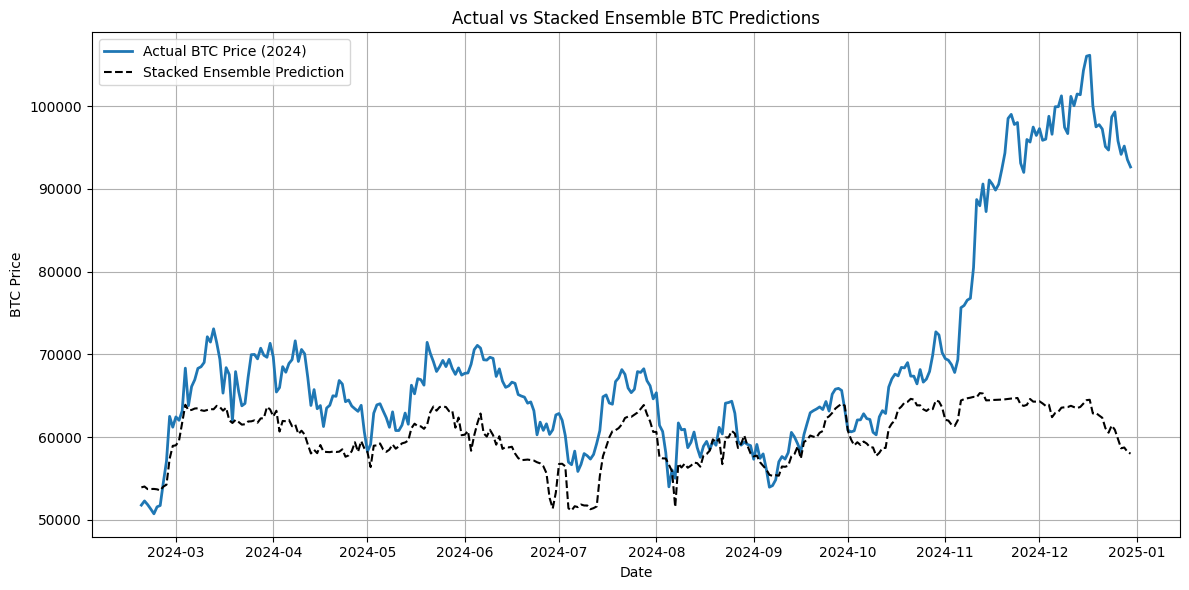

Meta-model RMSE: 14228.126348768275
Simple average RMSE: 18259.34323472814


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Get the final stacked prediction from the meta-model
stacked_ensemble_pred = meta_model.predict(meta_X_test)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(btc_2024.index, y_test, label='Actual BTC Price (2024)', linewidth=2)
plt.plot(btc_2024.index, stacked_ensemble_pred, label='Stacked Ensemble Prediction', linestyle='--', color='black')
plt.title('Actual vs Stacked Ensemble BTC Predictions')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
from sklearn.metrics import mean_squared_error
import numpy as np

# Naive ensemble
simple_ensemble = (rf_pred_test + lstm_pred_test + auto_pred_test) / 3

# RMSE for meta-model
mse_meta = mean_squared_error(y_test, stacked_ensemble_pred)
rmse_meta = np.sqrt(mse_meta)

# RMSE for simple average ensemble
mse_simple = mean_squared_error(y_test, simple_ensemble)
rmse_simple = np.sqrt(mse_simple)

print("Meta-model RMSE:", rmse_meta)
print("Simple average RMSE:", rmse_simple)


In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to handle NaN values (if any) in the predictions
def handle_nan(predictions):
    # Replace NaN with zeros, or you can use np.nanmean(predictions) to replace NaN with the mean
    predictions = np.nan_to_num(predictions, nan=0.0)
    return predictions

# Calculate metrics for each model's predictions
def calculate_metrics(actual, predictions):
    predictions = handle_nan(predictions)
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predictions)
    return mae, mse, rmse, r2

# Random Forest metrics
rf_mae, rf_mse, rf_rmse, rf_r2 = calculate_metrics(test_y, rf_predictions)
print(f"Random Forest - MAE: {rf_mae}, MSE: {rf_mse}, RMSE: {rf_rmse}, R2: {rf_r2}")

# AutoReg metrics
auto_mae, auto_mse, auto_rmse, auto_r2 = calculate_metrics(test_y, auto_predictions)
print(f"AutoReg - MAE: {auto_mae}, MSE: {auto_mse}, RMSE: {auto_rmse}, R2: {auto_r2}")

# LSTM metrics (handling NaNs)
lstm_mae, lstm_mse, lstm_rmse, lstm_r2 = calculate_metrics(test_y, lstm_predictions)
print(f"LSTM - MAE: {lstm_mae}, MSE: {lstm_mse}, RMSE: {lstm_rmse}, R2: {lstm_r2}")

# Ensemble metrics (handling NaNs)
ensemble_mae, ensemble_mse, ensemble_rmse, ensemble_r2 = calculate_metrics(test_y, ensemble_predictions)
print(f"Ensemble - MAE: {ensemble_mae}, MSE: {ensemble_mse}, RMSE: {ensemble_rmse}, R2: {ensemble_r2}")


Random Forest - MAE: 4742.103646891564, MSE: 26157403.45984503, RMSE: 5114.430902832203, R2: 0.028458187573029425
AutoReg - MAE: 3476.7630276484147, MSE: 21833785.116377406, RMSE: 4672.663599744519, R2: 0.18904660408399754
LSTM - MAE: 2269.3633502650177, MSE: 8441302.603785295, RMSE: 2905.391987974307, R2: 0.6864719985102581
Ensemble - MAE: 2524.9917052227725, MSE: 10252445.921781374, RMSE: 3201.944084736861, R2: 0.6192022687592864


## Insert run metrics after tuned model here 


c:\Users\S\anaconda3\envs\mlenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


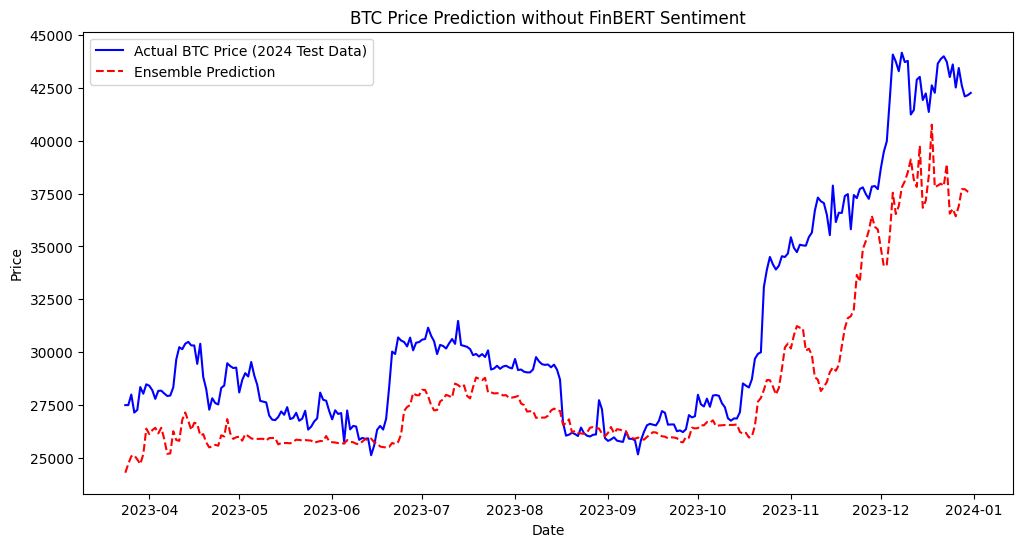

: 

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the BTC price data
btc_df = pd.read_csv('btc_2020_2024.csv', parse_dates=['Date'], index_col='Date')

# Ensure data is sorted by date
btc_df = btc_df.sort_index()

# Separate 2024 data (prediction target)
btc_2020_2023 = btc_df.loc[btc_df.index < '2024-01-01'].copy()
btc_2024 = btc_df.loc[btc_df.index >= '2024-01-01'].copy()

# Calculate technical indicators on 2020-2023 data
btc_2020_2023 = btc_2020_2023.copy()
btc_2020_2023['SMA_50'] = btc_2020_2023['Close_BTC-USD'].rolling(window=50).mean()
btc_2020_2023['EMA_50'] = btc_2020_2023['Close_BTC-USD'].ewm(span=50, adjust=False).mean()

# Remove NaNs from the data before training
btc_2020_2023 = btc_2020_2023.dropna(subset=['SMA_50', 'EMA_50'])

# Prepare the target variable (BTC price) for 2020-2023
y = btc_2020_2023["Close_BTC-USD"].values

# Prepare the features (X) for 2020-2023
feature_columns = ['SMA_50', 'EMA_50']
X = btc_2020_2023[feature_columns].values

# Split data into training and test sets (no 2024 data in training)
train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(train_X, train_y)
best_rf_model = grid_search.best_estimator_

# Fit Autoregressive model (AutoReg) with tuned lag
lag = 5  # Adjust as needed
auto_model = AutoReg(train_y, lags=lag).fit()

# Prepare data for LSTM model with technical indicators
train_X_lstm = np.reshape(train_X, (train_size, 1, train_X.shape[1]))  # Reshape to 3D
test_X_lstm = np.reshape(test_X, (len(test_X), 1, test_X.shape[1]))  # Reshape to 3D
train_y_lstm = train_y.reshape(-1, 1)

# Define and train LSTM model with hyperparameter tuning
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, train_X.shape[1])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(train_X_lstm, train_y_lstm, epochs=50, verbose=0)

# Get predictions from each model on the test set (2024 data will be used for predictions only)
rf_predictions = best_rf_model.predict(test_X)
auto_predictions = auto_model.predict(start=len(train_y), end=len(y)-1, dynamic=False)
lstm_predictions = lstm_model.predict(test_X_lstm).flatten()

# Adjust the length of LSTM predictions to match the length of RF and AutoReg predictions
lstm_predictions = lstm_predictions[:len(rf_predictions)]  # Ensure LSTM has the same length as RF and AutoReg

# Ensemble predictions
ensemble_predictions = (rf_predictions * 0.4 + lstm_predictions * 0.4 + auto_predictions * 0.2)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(btc_2020_2023.index[train_size:], test_y, label='Actual BTC Price (2024 Test Data)', color='blue')
plt.plot(btc_2020_2023.index[train_size:], ensemble_predictions, label='Ensemble Prediction', color='red', linestyle='dashed')
plt.legend()
plt.title('BTC Price Prediction without FinBERT Sentiment')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [21]:
print("Random Forest Predictions:", rf_predictions[:10])
print("AutoReg Predictions:", auto_predictions[:10])
print("LSTM Predictions:", lstm_predictions[:10])
print("Ensemble Predictions:", ensemble_predictions[:10])


Random Forest Predictions: [21841.62003906 21704.23392578 21910.43914062 21923.13724609
 22007.70792969 22051.79777344 21677.55892578 21685.44275391
 21979.98371094 21468.14335938]
AutoReg Predictions: [24188.35785488 24286.39389922 24416.37072124 24519.07533154
 24547.42011656 24582.21680648 24616.68622449 24648.39376244
 24677.3882382  24706.56740145]
LSTM Predictions: [nan nan nan nan nan nan nan nan nan nan]
Ensemble Predictions: [nan nan nan nan nan nan nan nan nan nan]


In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to handle NaN values (if any) in the predictions
def handle_nan(predictions):
    # Replace NaN with zeros, or you can use np.nanmean(predictions) to replace NaN with the mean
    predictions = np.nan_to_num(predictions, nan=0.0)
    return predictions

# Calculate metrics for each model's predictions
def calculate_metrics(actual, predictions):
    predictions = handle_nan(predictions)
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predictions)
    return mae, mse, rmse, r2

# Random Forest metrics
rf_mae, rf_mse, rf_rmse, rf_r2 = calculate_metrics(test_y, rf_predictions)
print(f"Random Forest - MAE: {rf_mae}, MSE: {rf_mse}, RMSE: {rf_rmse}, R2: {rf_r2}")

# AutoReg metrics
auto_mae, auto_mse, auto_rmse, auto_r2 = calculate_metrics(test_y, auto_predictions)
print(f"AutoReg - MAE: {auto_mae}, MSE: {auto_mse}, RMSE: {auto_rmse}, R2: {auto_r2}")

# LSTM metrics (handling NaNs)
lstm_mae, lstm_mse, lstm_rmse, lstm_r2 = calculate_metrics(test_y, lstm_predictions)
print(f"LSTM - MAE: {lstm_mae}, MSE: {lstm_mse}, RMSE: {lstm_rmse}, R2: {lstm_r2}")

# Ensemble metrics (handling NaNs)
ensemble_mae, ensemble_mse, ensemble_rmse, ensemble_r2 = calculate_metrics(test_y, ensemble_predictions)
print(f"Ensemble - MAE: {ensemble_mae}, MSE: {ensemble_mse}, RMSE: {ensemble_rmse}, R2: {ensemble_r2}")


Random Forest - MAE: 4742.103646891564, MSE: 26157403.45984503, RMSE: 5114.430902832203, R2: 0.028458187573029425
AutoReg - MAE: 3476.7630276484147, MSE: 21833785.116377406, RMSE: 4672.663599744519, R2: 0.18904660408399754
LSTM - MAE: 2262.7650797813603, MSE: 8299851.913237407, RMSE: 2880.9463572301042, R2: 0.6917257791645539
Ensemble - MAE: 2503.9155110121524, MSE: 10129772.62021068, RMSE: 3182.730371899366, R2: 0.6237586170959


            Close_BTC-USD  High_BTC-USD  Low_BTC-USD  Open_BTC-USD  \
Date                                                                 
2020-01-01    7200.174316   7254.330566  7174.944336   7194.892090   
2020-01-02    6985.470215   7212.155273  6935.270020   7202.551270   
2020-01-03    7344.884277   7413.715332  6914.996094   6984.428711   
2020-01-04    7410.656738   7427.385742  7309.514160   7345.375488   
2020-01-05    7411.317383   7544.497070  7400.535645   7410.451660   

            Volume_BTC-USD  
Date                        
2020-01-01     18565664997  
2020-01-02     20802083465  
2020-01-03     28111481032  
2020-01-04     18444271275  
2020-01-05     19725074095  


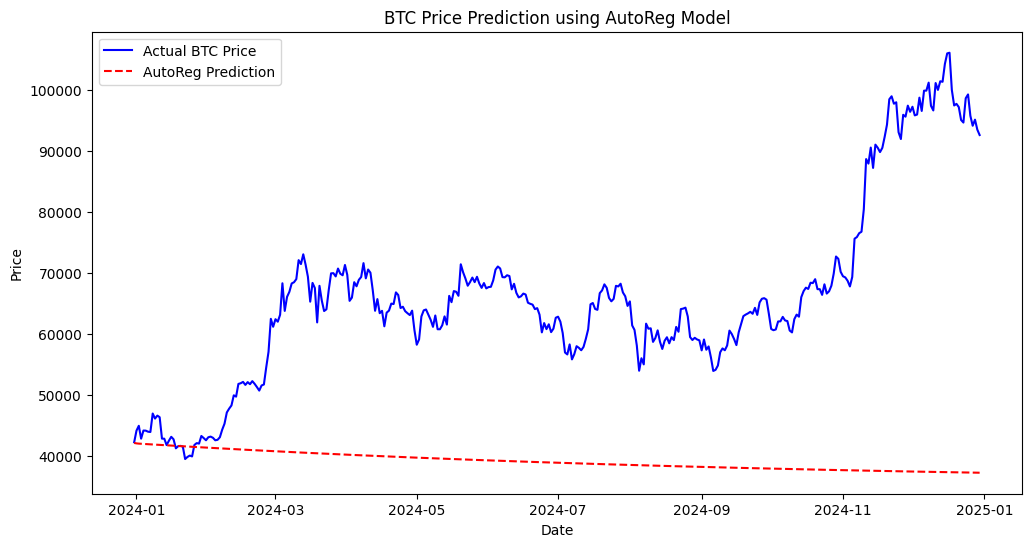

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Load the BTC price data from the CSV file
btc_df = pd.read_csv('btc_2020_2024.csv', parse_dates=['Date'], index_col='Date')

# Ensure data is sorted by date
btc_df.sort_index(inplace=True)

# Display first few rows of the dataframe to ensure it loaded correctly
print(btc_df.head())

# Prepare the target variable (BTC price)
y = btc_df["Close_BTC-USD"].values
X = np.arange(len(y)).reshape(-1, 1)  # Simple time index feature

# Split data into training and test sets
train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Fit Autoregressive model (AutoReg)
lag = 5  # Adjust as needed
auto_model = AutoReg(train_y, lags=lag).fit()

# Generate AutoReg predictions
auto_predictions = auto_model.predict(start=len(train_y), end=len(y)-1, dynamic=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[train_size:], test_y, label='Actual BTC Price', color='blue')
plt.plot(btc_df.index[train_size:], auto_predictions, label='AutoReg Prediction', color='red', linestyle='dashed')
plt.legend()
plt.title('BTC Price Prediction using AutoReg Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [1]:
import yfinance as yf

def get_btc_data():
    # Download BTC-USD data from Yahoo Finance
    btc = yf.download('BTC-USD', start='2020-01-01', end='2024-01-01', progress=False)
    
    # Only keep the 'Close' price
    btc = btc[['Close']]
    
    # Calculate the return as the percentage change in closing price
    btc['Return'] = btc['Close'].pct_change()  # Calculate return as percentage change of closing price
    
    # Drop rows with missing data
    btc.dropna(inplace=True)
    
    return btc

# Example usage
btc_data = get_btc_data()
print(btc_data.head())  # Display the first few rows of the BTC data



1 Failed download:
['BTC-USD']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Empty DataFrame
Columns: [(Close, BTC-USD), (Return, )]
Index: []


[*********************100%***********************]  20 of 20 completed
C:\Users\S\AppData\Local\Temp\ipykernel_36524\2878482506.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)  # Forward fill missing values
[*********************100%***********************]  1 of 1 completed
C:\Users\S\AppData\Local\Temp\ipykernel_36524\2878482506.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_cap.fillna(method="ffill", inplace=True)


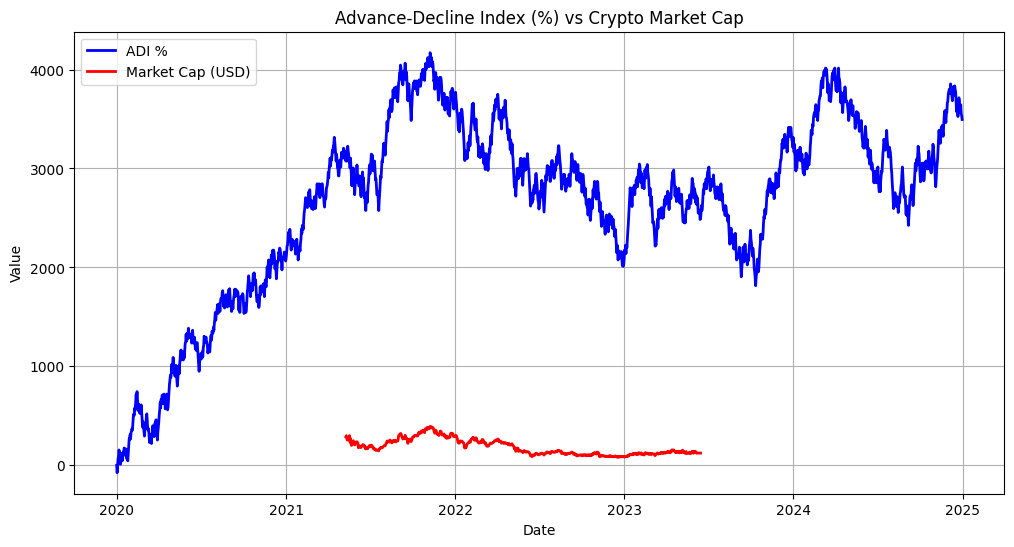

In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of top 100 crypto tickers
crypto_tickers = [
    "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD", "ADA-USD", "DOGE-USD", "MATIC-USD", "DOT-USD", "LTC-USD",
    "TRX-USD", "BCH-USD", "LINK-USD", "XLM-USD", "ATOM-USD", "ETC-USD", "FIL-USD", "HBAR-USD", "APE-USD", "VET-USD",
]

# Fetch historical data since 2020
start_date = "2020-01-01"
end_date = "2025-01-01"

# Download close prices
df = yf.download(crypto_tickers, start=start_date, end=end_date, interval="1d")["Close"]
df.fillna(method="ffill", inplace=True)  # Forward fill missing values

# Compute Advances and Declines
daily_changes = df.diff().fillna(0)
advances = (daily_changes > 0).sum(axis=1)
declines = (daily_changes < 0).sum(axis=1)

# Compute ADI %
adl = (advances - declines).cumsum()
adl_pct = (adl / len(df.columns)) * 100  # Convert to percentage

# Fetch total crypto market cap
market_cap = yf.download("TCAP-USD", start=start_date, end=end_date, interval="1d")["Close"]
market_cap.fillna(method="ffill", inplace=True)

# Plot ADI % and Market Cap
plt.figure(figsize=(12, 6))
plt.plot(adl_pct, label="ADI %", color="blue", linewidth=2)
plt.plot(market_cap, label="Market Cap (USD)", color="red", linewidth=2)  # Plot actual market cap
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Advance-Decline Index (%) vs Crypto Market Cap")
plt.legend()
plt.grid()
plt.show()


[*********************100%***********************]  90 of 90 completed

2 Failed downloads:
['COMP-USD', 'GRT-USD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-03-13 16:59:33.516543 -> 2025-03-13 16:59:33.516543)')
C:\Users\S\AppData\Local\Temp\ipykernel_36524\1541914025.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


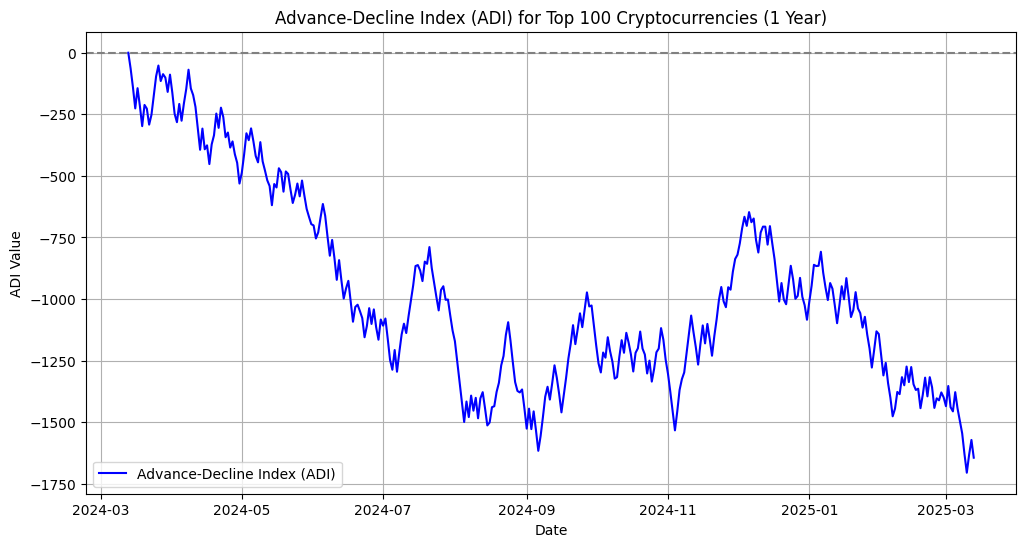

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# List of top 100 crypto tickers (excluding altcoin index)
crypto_tickers = [
    "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD", "ADA-USD", "DOGE-USD", "MATIC-USD", "DOT-USD", "LTC-USD",
    "TRX-USD", "BCH-USD", "LINK-USD", "XLM-USD", "ATOM-USD", "ETC-USD", "FIL-USD", "HBAR-USD", "APE-USD", "VET-USD",
    "ICP-USD", "GRT-USD", "SAND-USD", "MANA-USD", "AXS-USD", "EGLD-USD", "QNT-USD", "FTM-USD", "NEAR-USD", "THETA-USD",
    "XTZ-USD", "LDO-USD", "AAVE-USD", "RNDR-USD", "CHZ-USD", "EOS-USD", "FLOW-USD", "KCS-USD", "ZEC-USD", "CRV-USD",
    "SNX-USD", "GALA-USD", "XEC-USD", "KAVA-USD", "MINA-USD", "RUNE-USD", "1INCH-USD", "ZIL-USD", "OMG-USD", "CELO-USD",
    "YFI-USD", "ANKR-USD", "COMP-USD", "SUSHI-USD", "BAT-USD", "BAND-USD", "OCEAN-USD", "BAL-USD", "ENS-USD", "STX-USD",
    "NEXO-USD", "SKL-USD", "LPT-USD", "KSM-USD", "CELR-USD", "DASH-USD", "CVC-USD", "XNO-USD", "PERP-USD", "AR-USD",
    "ICX-USD", "RAY-USD", "ALICE-USD", "YGG-USD", "UOS-USD", "STORJ-USD", "COTI-USD", "CTSI-USD", "SXP-USD", "RSR-USD",
    "MTL-USD", "REQ-USD", "DGB-USD", "UMA-USD", "KMD-USD", "ARK-USD", "LRC-USD", "MLN-USD", "REN-USD", "POND-USD"
]

# Fetch historical data for the last 1 year
start_date = datetime.today() - timedelta(days=365)
end_date = datetime.today()

# Download daily close prices
df = yf.download(crypto_tickers, start=start_date, end=end_date, interval="1d")["Close"]

# Drop cryptos that didn't return data
df = df.dropna(axis=1, how="all")

# Fill missing values with previous day's close price (forward fill)
df.fillna(method="ffill", inplace=True)

# Calculate Advances (+1), Declines (-1), and Unchanged (0)
daily_changes = df.diff().fillna(0)
advances = (daily_changes > 0).sum(axis=1)
declines = (daily_changes < 0).sum(axis=1)

# Compute Advance-Decline Line (ADL)
adl = (advances - declines).cumsum()

# Plot the 1-Year ADI trend
plt.figure(figsize=(12, 6))
plt.plot(adl, label="Advance-Decline Index (ADI)", color="blue")
plt.axhline(y=0, color="gray", linestyle="--")
plt.xlabel("Date")
plt.ylabel("ADI Value")
plt.title("Advance-Decline Index (ADI) for Top 100 Cryptocurrencies (1 Year)")
plt.legend()
plt.grid()
plt.show()


# Hyperparameter tuning 

In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import keras_tuner as kt
from transformers import pipeline

# Load the BTC price data
btc_df = pd.read_csv('btc_2020_2024.csv', parse_dates=['Date'], index_col='Date')

# Load and process the chat file
chat_file = "Sentiment1.txt"
with open(chat_file, "r", encoding="utf-8") as file:
    chat_data = file.read()

# Extract messages
pattern = r"Time: (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\nMessage: (.*?)\n(?:-|\Z)"
matches = re.findall(pattern, chat_data, re.DOTALL)

# Convert to DataFrame
sentiment_df = pd.DataFrame(matches, columns=["Timestamp", "Message"])
sentiment_df["Timestamp"] = pd.to_datetime(sentiment_df["Timestamp"])

# Initialize FinBERT sentiment analysis pipeline
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert", device=0)

def get_finbert_sentiment(text):
    result = finbert(text)[0]['label']
    return 1 if result == "positive" else -1 if result == "negative" else 0

sentiment_df['FinBERT_Score'] = sentiment_df['Message'].apply(get_finbert_sentiment)

daily_sentiment = sentiment_df.groupby(sentiment_df['Timestamp'].dt.date)['FinBERT_Score'].mean().rename('FinBERT_Score')

btc_df = btc_df.merge(daily_sentiment, left_index=True, right_index=True, how='left')
btc_df['FinBERT_Score'].fillna(0, inplace=True)

btc_df = btc_df.sort_index()

btc_2020_2023 = btc_df.loc[btc_df.index < '2024-01-01'].copy()
btc_2024 = btc_df.loc[btc_df.index >= '2024-01-01'].copy()

btc_2020_2023['SMA_50'] = btc_2020_2023['Close_BTC-USD'].rolling(window=50).mean()
btc_2020_2023['EMA_50'] = btc_2020_2023['Close_BTC-USD'].ewm(span=50, adjust=False).mean()

btc_2020_2023.dropna(subset=['SMA_50', 'EMA_50', 'FinBERT_Score'], inplace=True)

y = btc_2020_2023["Close_BTC-USD"].values
feature_columns = ['SMA_50', 'EMA_50', 'FinBERT_Score']
X = btc_2020_2023[feature_columns].values

train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Hyperparameter tuning for Random Forest
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, scoring='neg_mean_squared_error')
rf_grid.fit(train_X, train_y)
rf_best = rf_grid.best_estimator_

# Hyperparameter tuning for AutoReg (optimal lag selection)
best_lag = None
best_aic = float('inf')
for lag in range(1, 21):
    try:
        model = AutoReg(train_y, lags=lag).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_lag = lag
    except:
        continue

auto_model = AutoReg(train_y, lags=best_lag).fit()

# Hyperparameter tuning for LSTM
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=30, max_value=100, step=10), activation='relu', input_shape=(1, train_X.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])), loss='mse')
    return model

tuner = kt.RandomSearch(build_lstm_model, objective='val_loss', max_trials=5, directory='tuner_data', project_name='LSTM_Tuning')
tuner.search(np.reshape(train_X, (train_size, 1, train_X.shape[1])), train_y, epochs=20, validation_split=0.2, verbose=0)
lstm_best = tuner.get_best_models(num_models=1)[0]

rf_predictions = rf_best.predict(test_X)
auto_predictions = auto_model.predict(start=len(train_y), end=len(y)-1, dynamic=False)
test_X_lstm = np.reshape(test_X, (len(test_X), 1, test_X.shape[1]))
lstm_predictions = lstm_best.predict(test_X_lstm).flatten()

lstm_predictions = lstm_predictions[:len(rf_predictions)]
ensemble_predictions = (rf_predictions * 0.4 + lstm_predictions * 0.4 + auto_predictions * 0.2)

plt.figure(figsize=(12, 6))
plt.plot(btc_2020_2023.index[train_size:], test_y, label='Actual BTC Price (2024 Test Data)', color='blue')
plt.plot(btc_2020_2023.index[train_size:], ensemble_predictions, label='Ensemble Prediction', color='red', linestyle='dashed')
plt.legend()
plt.title('BTC Price Prediction with Hyperparameter Tuning')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


ModuleNotFoundError: No module named 'keras_tuner'